###  Importing  Required Libraries

In [ ]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

###  now with the help of Kaggle API we try to Access the Dataset

In [ ]:
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

###  Download and Extract Lung Disease Dataset

In [ ]:
!kaggle datasets download -d fatemehmehrparvar/lung-disease

Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/34.9M [00:00<?, ?B/s]
100% 34.9M/34.9M [00:00<00:00, 1.37GB/s]


In [ ]:
with zipfile.ZipFile("lung-disease.zip", 'r') as zip_ref:
    zip_ref.extractall("lung_disease_data")
print("Dataset extracted.")

Dataset extracted.


###  Checking Folder Structure

In [ ]:
for root, dirs, files in os.walk("lung_disease_data"):
    print("Root:", root)
    print("Subfolders:", dirs)
    break

Root: lung_disease_data
Subfolders: ['Lung X-Ray Image']


### Load and Prepare Image Dataset

In [ ]:
# Define dataset path and parameters
dataset_path = "lung_disease_data/Lung X-Ray Image/Lung X-Ray Image"
img_size = (224, 224)
batch_size = 32

# Load training dataset (80% split)
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Load validation dataset (20% split)
val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names from folder structure
class_names = train_ds.class_names
print("Classes:", class_names)


Found 3475 files belonging to 3 classes.
Using 2780 files for training.
Found 3475 files belonging to 3 classes.
Using 695 files for validation.
Classes: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


### Lets do some Exploratory Data Analysis: Visualizing Sample Images

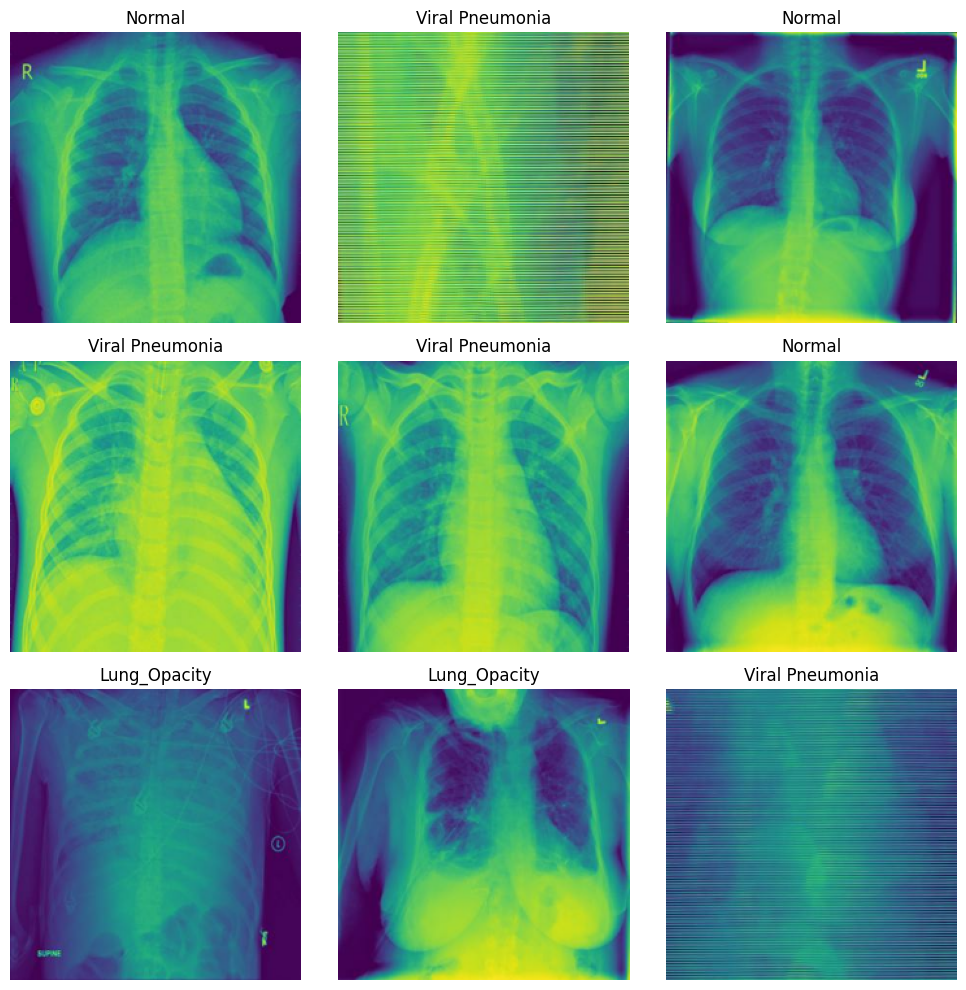

In [ ]:
# Visualize 9 random sample images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()


/tmp/ipython-input-10-1170054539.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


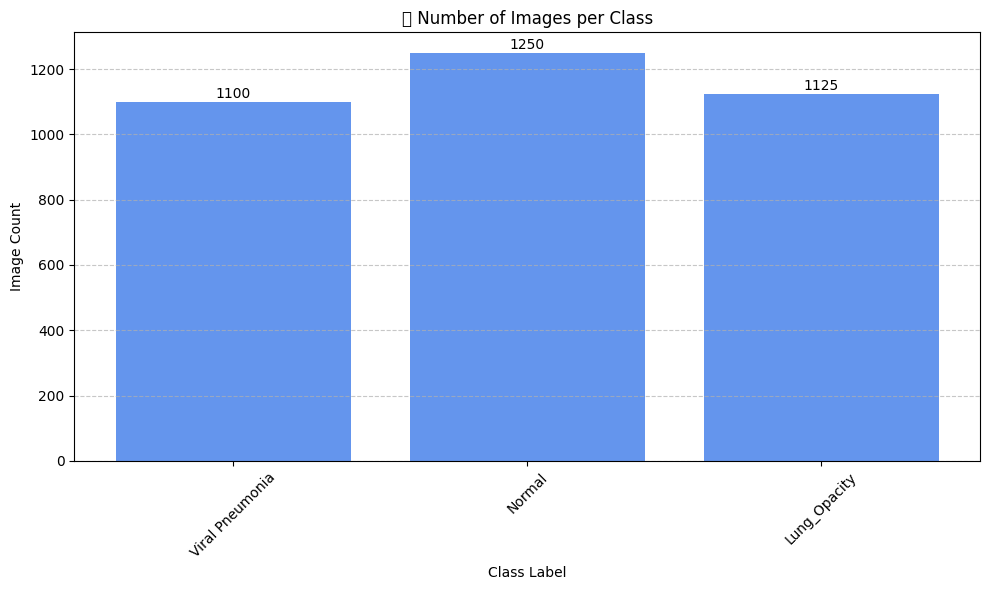

In [ ]:

##checking the no. of images with the graph visulaization
# Dataset path
data_dir = "lung_disease_data/Lung X-Ray Image/Lung X-Ray Image"

# Count images per class
class_counts = {}
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        count = len([
            f for f in os.listdir(label_path)
            if os.path.isfile(os.path.join(label_path, f))
        ])
        class_counts[label] = count

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='cornflowerblue')
plt.title("📊 Number of Images per Class")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


###  Building a Custom CNN Model

In [ ]:
# Define a simple custom CNN model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model with optimizer, loss function, and evaluation metric
cnn_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

###  Training the Custom CNN with Early Stopping

In [ ]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop]
)


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.7083 - loss: 1.4229 - val_accuracy: 0.4878 - val_loss: 1.2735
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8642 - loss: 0.4199 - val_accuracy: 0.8043 - val_loss: 0.4919
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8854 - loss: 0.3159 - val_accuracy: 0.8173 - val_loss: 0.3780
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9019 - loss: 0.2401 - val_accuracy: 0.8734 - val_loss: 0.3518
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9114 - loss: 0.2147 - val_accuracy: 0.8748 - val_loss: 0.3129
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9184 - loss: 0.2110 - val_accuracy: 0.8763 - val_loss: 0.3355
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9331 - loss: 0.1712 - val_accuracy: 0.8691 - val_loss: 0.3845
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9467 - loss: 0.1395 - val_accuracy: 0.8719

###  Accuracy and Loss Curves for Custom CNN

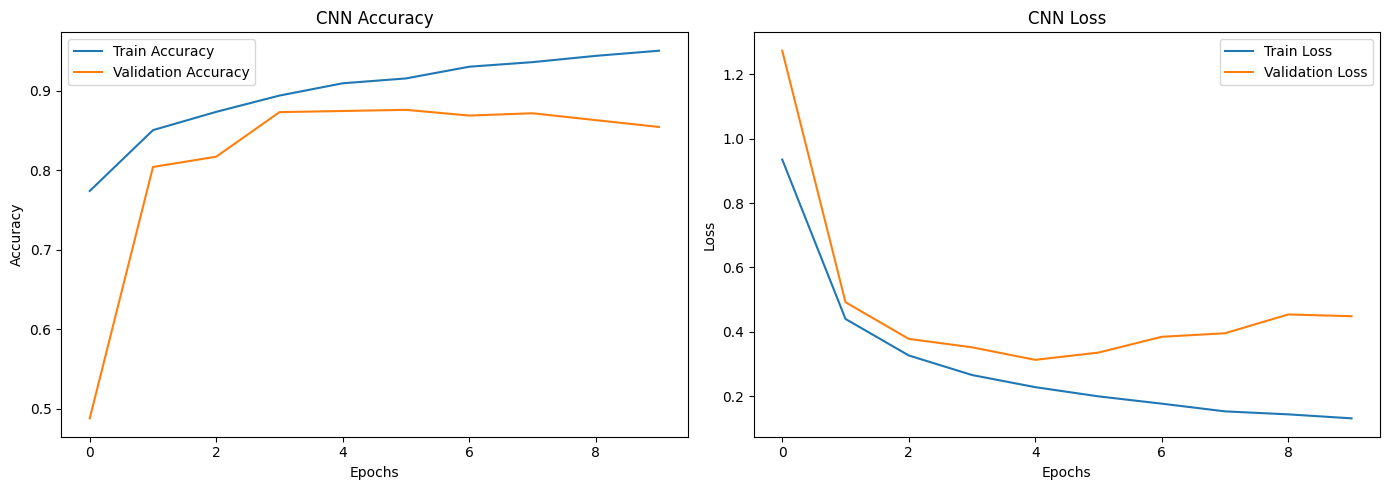

In [ ]:
# Plot training vs validation accuracy and loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###  Predictions from Custom CNN on Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


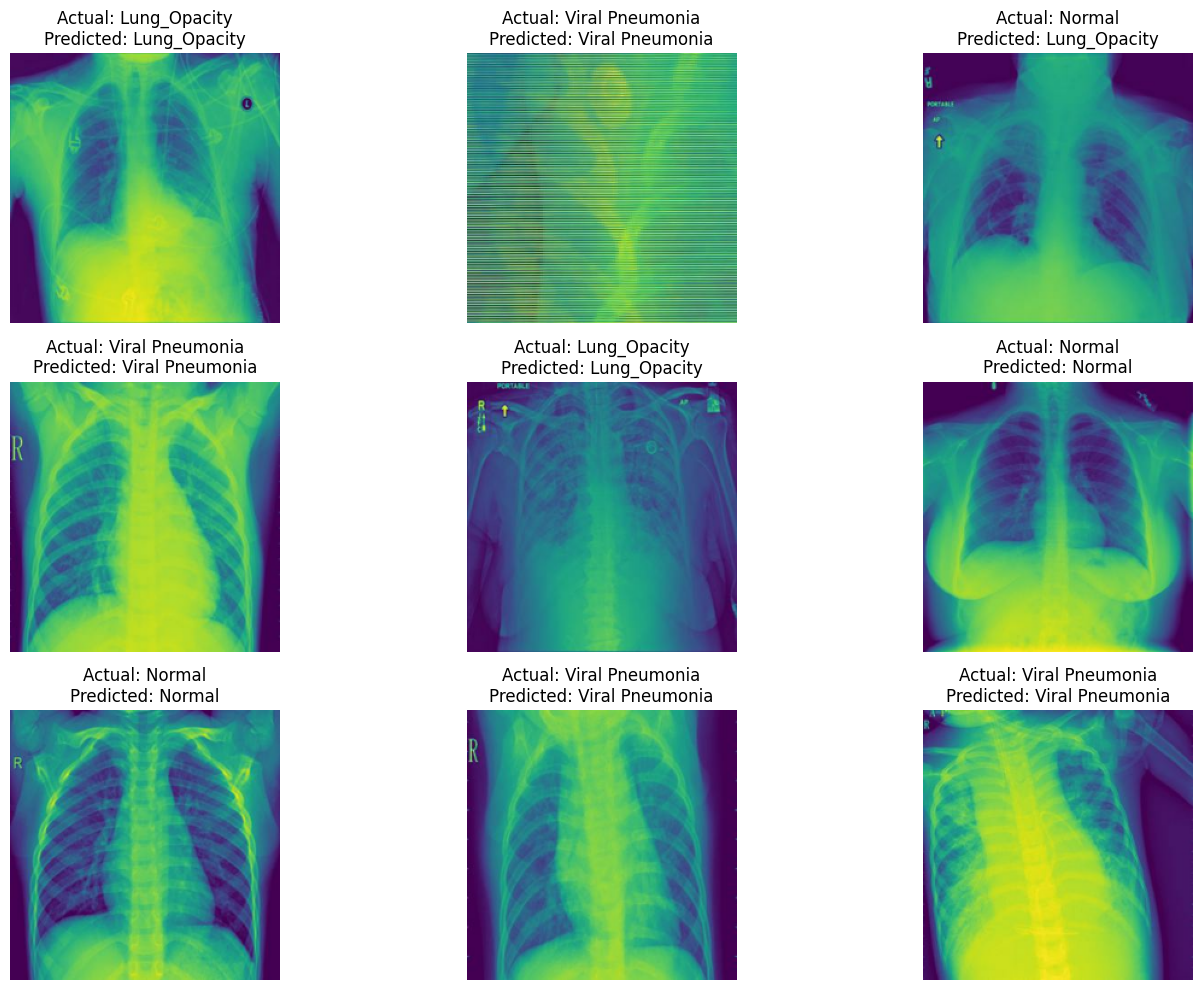

In [ ]:
# Predict and visualize 9 validation images with actual vs predicted labels
for images, labels in val_ds.take(1):
    predictions = cnn_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    plt.figure(figsize=(15, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_classes[i]]}\nPredicted: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


###  Classification Report and Confusion Matrix for Custom CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


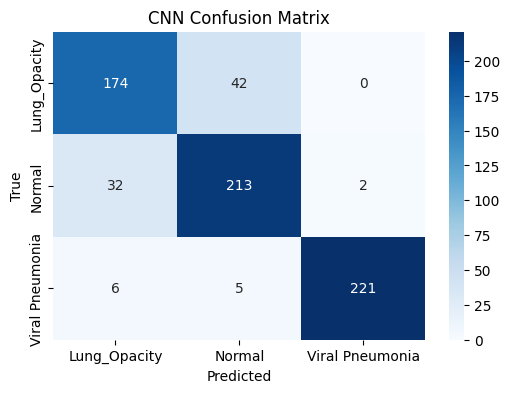

CNN Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity       0.82      0.81      0.81       216
         Normal       0.82      0.86      0.84       247
Viral Pneumonia       0.99      0.95      0.97       232

       accuracy                           0.87       695
      macro avg       0.88      0.87      0.87       695
   weighted avg       0.88      0.87      0.88       695



In [ ]:
# Generate predictions for the entire validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = cnn_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("CNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
